<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        298

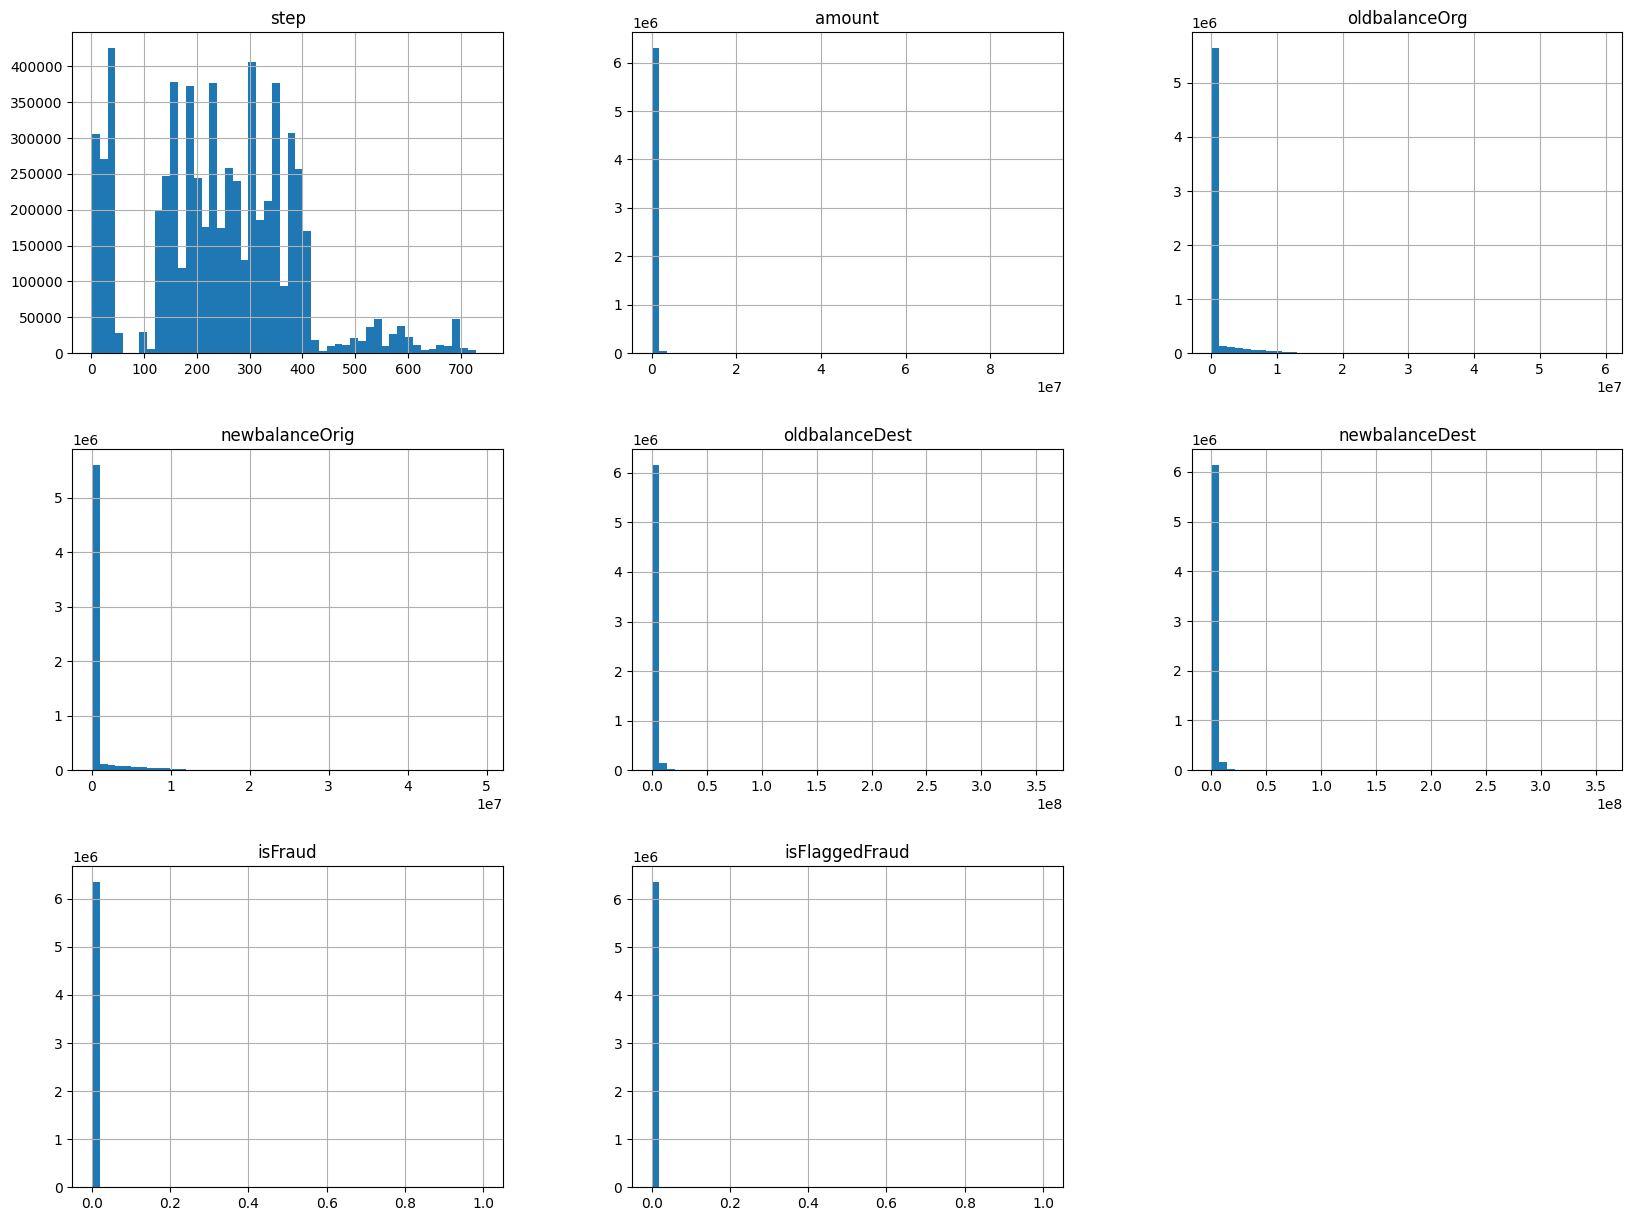

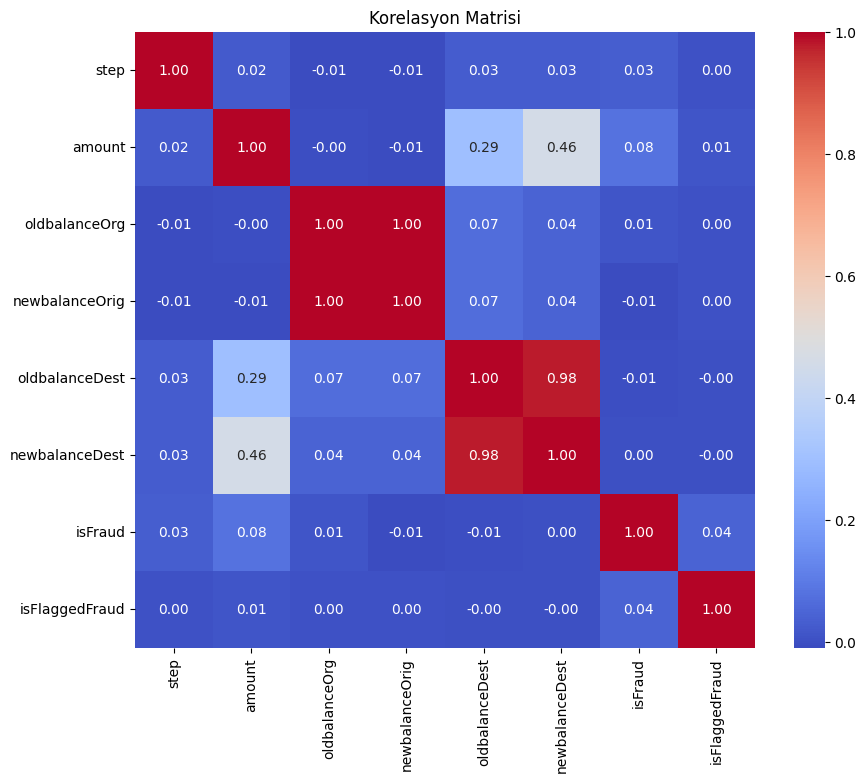

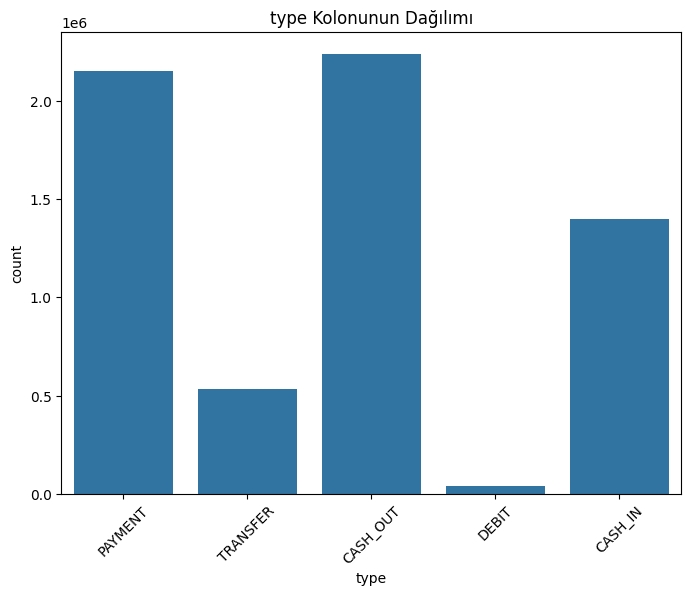

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# 1. Veri Setini Yükleme ve İlk Analizler
file_path = r"C:\Users\Admin\Desktop\PS_20174392719_1491204439457_log.csv"
data = pd.read_csv(file_path, encoding='ISO-8859-1', on_bad_lines='skip')

# Veri setine genel bir bakış
print(data.info())
print(data.head())

# Eksik değerleri kontrol etme
print(data.isnull().sum())

# Sütunların istatistiksel özeti
print(data.describe())

# 4. Keşifsel Veri Analizi (EDA)
# Sayısal sütunları seçip histogramlarını çizme
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

if len(numeric_columns) > 0:
    data[numeric_columns].hist(bins=50, figsize=(20, 15))
    plt.show()

# Korelasyon matrisi için yalnızca sayısal sütunları seçme
if len(numeric_columns) > 0:
    plt.figure(figsize=(10, 8))
    corr_matrix = data[numeric_columns].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Korelasyon Matrisi')
    plt.show()
else:
    print("Sayısal sütunlar bulunamadı.")

# Kategorik sütunların dağılımını görselleştirme
categorical_columns = data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=data, x=column)
    plt.title(f'{column} Kolonunun Dağılımı')
    plt.xticks(rotation=45)
    plt.show()

# 5. Veri Ön İşleme
# Eksik verileri silme
data_cleaned = data.dropna()

# Kategorik değişkenleri One-Hot Encoding ile dönüştürme
data_encoded = pd.get_dummies(data_cleaned, drop_first=True)

# Veriyi normalleştirme
scaler = StandardScaler()
numeric_columns = data_encoded.select_dtypes(include=['float64', 'int64']).columns

# Sayısal verileri normalize etme
if len(numeric_columns) > 0:
    data_encoded[numeric_columns] = scaler.fit_transform(data_encoded[numeric_columns])

# Hedef değişkeni ve özellikleri ayırma
# 'isFraud' hedef değişkeni
target_column = 'isFraud'

if target_column in data_encoded.columns:
    X = data_encoded.drop(target_column, axis=1)
    y = data_encoded[target_column]
else:
    print(f"Hedef sütun '{target_column}' bulunamadı. Sütun adını kontrol edin.")

# Veriyi eğitim ve test kümelerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Algoritma Seçimi ve Hiperparametre Optimizasyonu

# Modelleri tanımlama
log_reg = LogisticRegression(max_iter=1000)
decision_tree = DecisionTreeClassifier()
svm = SVC()
knn = KNeighborsClassifier()

# Modellerin isimleri ve nesneleri
models = {
    'Lojistik Regresyon': log_reg,
    'Karar Ağacı': decision_tree,
    'SVM': svm,
    'KNN': knn
}

# Her bir modeli eğitme ve çapraz doğrulama skoru hesaplama
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} doğruluk skoru (cross validation): {np.mean(scores)}")

# SVM modeli için hiperparametre optimizasyonu
param_grid_svc = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01],
    'kernel': ['linear', 'rbf']
}

grid_search_svc = GridSearchCV(svm, param_grid_svc, cv=5, scoring='accuracy')
grid_search_svc.fit(X_train, y_train)

print(f"SVM En iyi parametreler: {grid_search_svc.best_params_}")
print(f"SVM En iyi doğruluk skoru: {grid_search_svc.best_score_}")

# KNN modeli için hiperparametre optimizasyonu
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)

print(f"KNN En iyi parametreler: {grid_search_knn.best_params_}")
print(f"KNN En iyi doğruluk skoru: {grid_search_knn.best_score_}")

# 7. Model Değerlendirme

# En iyi SVM modelini değerlendirme
y_pred_svc = grid_search_svc.best_estimator_.predict(X_test)

conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svc, annot=True, fmt="d", cmap="Blues")
plt.title('SVM Karışıklık Matrisi')
plt.ylabel('Gerçek Etiketler')
plt.xlabel('Tahmin Etiketleri')
plt.show()

accuracy_svc = accuracy_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc, average='weighted')
recall_svc = recall_score(y_test, y_pred_svc, average='weighted')
f1_svc = f1_score(y_test, y_pred_svc, average='weighted')

print(f"SVM Doğruluk: {accuracy_svc}")
print(f"SVM Kesinlik (Precision): {precision_svc}")
print(f"SVM Duyarlılık (Recall): {recall_svc}")
print(f"SVM F1 Puanı: {f1_svc}")

# KNN modeli için değerlendirme
y_pred_knn = grid_search_knn.best_estimator_.predict(X_test)

conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues")
plt.title('KNN Karışıklık Matrisi')
plt.ylabel('Gerçek Etiketler')
plt.xlabel('Tahmin Etiketleri')
plt.show()

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

print(f"KNN Doğruluk: {accuracy_knn}")
print(f"KNN Kesinlik (Precision): {precision_knn}")
print(f"KNN Duyarlılık (Recall): {recall_knn}")
print(f"KNN F1 Puanı: {f1_knn}")
